# Stock Price machine Learning

-----------------------------------
## Historical Data Pull for Amazon

In [2]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import numpy as np
import warnings

# Dates
today = pd.Timestamp.today().strftime('%Y-%m-%d')
one_year_ago = (pd.Timestamp.today() - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Ticker symbol
ticker = 'AMZN'

# Data Pull
hist_data = yf.download(ticker, start=one_year_ago, end=today,progress=False)

# Ensure data is in a DataFrame with datetime index
df = pd.DataFrame(hist_data)
df.index = pd.to_datetime(df.index)  # Ensure datetime index
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-06,128.250000,128.729996,127.370003,128.360001,128.360001,40639900
2023-07-07,128.589996,130.970001,128.130005,129.779999,129.779999,41928700
2023-07-10,129.070007,129.279999,125.919998,127.129997,127.129997,61889300
2023-07-11,127.750000,129.770004,127.349998,128.779999,128.779999,49951500
2023-07-12,130.309998,131.259995,128.830002,130.800003,130.800003,54022800
...,...,...,...,...,...,...
2024-06-28,197.729996,198.850006,192.500000,193.250000,193.250000,76930200
2024-07-01,193.490005,198.300003,192.820007,197.199997,197.199997,41192000
2024-07-02,197.279999,200.429993,195.929993,200.000000,200.000000,45600000


-----------------------------------
### Adjusted Close Plot for Visual

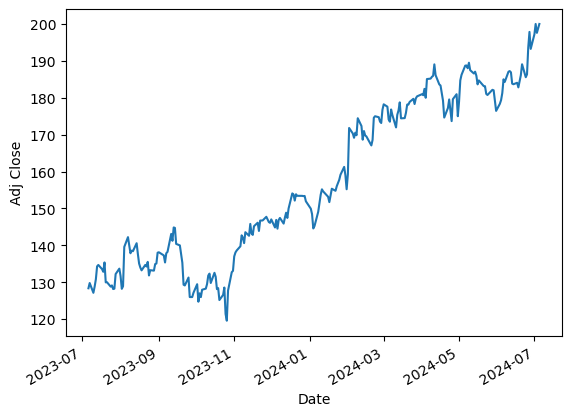

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

-----------------------------------
## Technical Indicator Calculations

In [ ]:
df.ta.indicators()

In [ ]:
# Calculate Moving Averages
df.ta.sma(length=7, append=True)
df.ta.sma(length=14, append=True)
df.ta.sma(length=30, append=True)
df.ta.sma(length=50, append=True)
df.ta.sma(length=200, append=True)

# Calculate Bollinger Bands
df.ta.bbands(length=20, append=True) #volatility

# Calculate RSI
df.ta.rsi(length=14, append=True)

# Calculate MACD 
df.ta.macd(fast=12, slow=26, append=True)

print(df)

### Good Data Pull so far with calculations 
More Technical Indicators can be added as we go. Now for some plotting to get some visuals of what the data looks like.

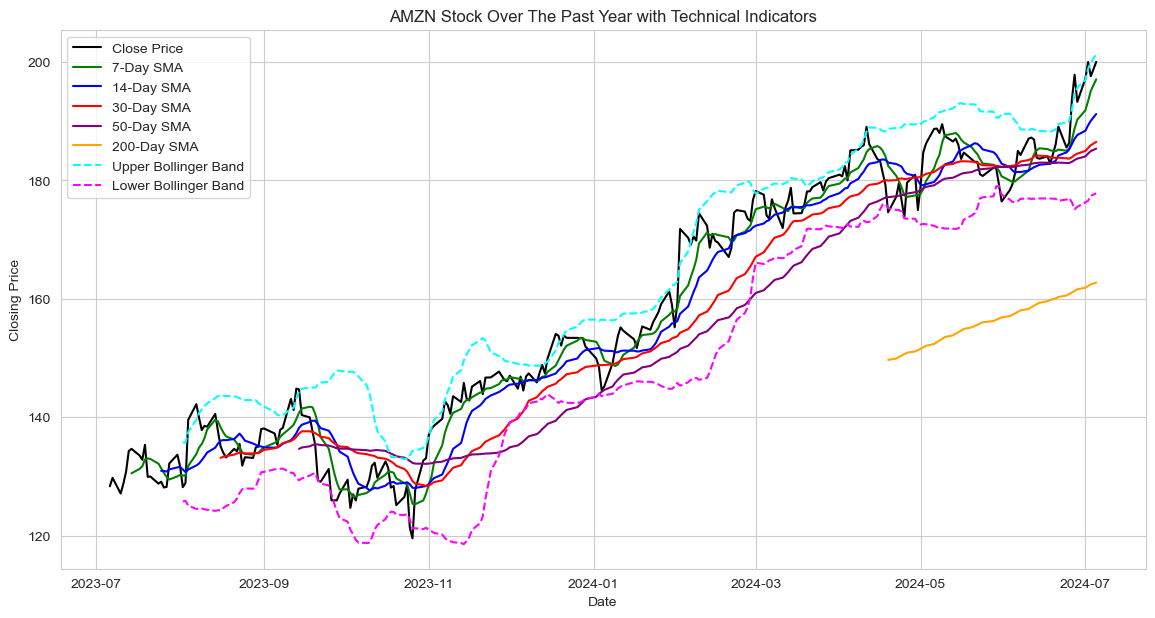

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize =(14,7))
# Moving Aveerages
plt.plot(df.index, df['Close'], label = 'Close Price', color = 'black')
plt.plot(df.index,df['SMA_7'],label = '7-Day SMA', color = 'green')
plt.plot(df.index, df['SMA_14'],label = '14-Day SMA',color = 'blue')
plt.plot(df.index, df['SMA_30'],label = '30-Day SMA', color = 'red')
plt.plot(df.index,df['SMA_50'], label = '50-Day SMA',color = 'purple')
plt.plot(df.index, df['SMA_200'], label = '200-Day SMA',color = 'orange')
# Bollinger Bands
plt.plot(df.index,df['BBU_20_2.0'],label = 'Upper Bollinger Band',color = 'cyan',linestyle = '--')
plt.plot(df.index,df['BBL_20_2.0'],label = 'Lower Bollinger Band',color = 'magenta',linestyle = '--')

plt.title('AMZN Stock Over The Past Year with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### Adding some more technical indicators

Pandas ta package not working synergistically with inputted close column for the dataframe.
Custom function below drawn from pandas_ta fixes the issue. 

In [7]:
# Function for missing drawdown from pandas_ta

from numpy import log as nplog
from numpy import seterr
from pandas import DataFrame
from pandas_ta.utils import get_offset, verify_series

def drawdown(close, offset=None, **kwargs) -> DataFrame:
    """Indicator: Drawdown (DD)"""
    # Validate Arguments
    close = verify_series(close)
    offset = get_offset(offset)

    # Calculate Result
    max_close = close.cummax()
    dd = max_close - close
    dd_pct = 1 - (close / max_close)

    _np_err = seterr()
    seterr(divide="ignore", invalid="ignore")
    dd_log = nplog(max_close) - nplog(close)
    seterr(divide=_np_err["divide"], invalid=_np_err["invalid"])

    # Offset
    if offset != 0:
        dd = dd.shift(offset)
        dd_pct = dd_pct.shift(offset)
        dd_log = dd_log.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        dd.fillna(kwargs["fillna"], inplace=True)
        dd_pct.fillna(kwargs["fillna"], inplace=True)
        dd_log.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        dd.fillna(method=kwargs["fill_method"], inplace=True)
        dd_pct.fillna(method=kwargs["fill_method"], inplace=True)
        dd_log.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    dd.name = "DD"
    dd_pct.name = f"{dd.name}_PCT"
    dd_log.name = f"{dd.name}_LOG"
    dd.category = dd_pct.category = dd_log.category = "performance"

    # Prepare DataFrame to return
    data = {dd.name: dd, dd_pct.name: dd_pct, dd_log.name: dd_log}
    df = DataFrame(data)
    df.name = dd.name
    df.category = dd.category

    return df


In [8]:
import pandas as pd
from pandas.api.extensions import register_dataframe_accessor

@register_dataframe_accessor("c_ta")
class CustomTAAccessor:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def drawdown(self, close_column="Close", offset=None, **kwargs):
        if close_column not in self._obj.columns:
            raise KeyError(f"Column '{close_column}' not found in DataFrame")
        close = self._obj[close_column]
        return drawdown(close, offset=offset, **kwargs)

#### Adding in the indicators

In [ ]:
# Full technical indicators minus other previous additions
df.ta.aberration(append=True)     # Aberration: Measures volatility
df.ta.above(above_value=160, append=True)  # Check if value is above 100
df.ta.accbands(append=True)      # Accumulation/Distribution Bands: Measure volatility
df.ta.ad(append=True)            # Accumulation/Distribution: Volume indicator
df.ta.adosc(append=True)         # Accumulation/Distribution Oscillator: Volume indicator
df.ta.adx(append=True)           # Average Directional Index: Measures trend strength
df.ta.alma(append=True)          # Arnaud Legoux Moving Average: Smoothed price data
df.ta.amat(append=True)          # Adaptative Moving Average Trend: Identifies trends
df.ta.ao(append=True)            # Awesome Oscillator: Measures momentum
df.ta.aobv(append=True)          # Above On Balance Volume: Volume indicator
df.ta.apo(append=True)           # Absolute Price Oscillator: Measures momentum
df.ta.aroon(append=True)         # Aroon: Identifies trend changes
df.ta.atr(append=True)           # Average True Range: Measures volatility
df.ta.below(below_value=50, append=True)  # Check if value is below 50
df.ta.bias(append=True)          # Bias: Measures deviation from a specified average
df.ta.bop(append=True)           # Balance of Power: Momentum indicator
df.ta.brar(append=True)          # (Bullish/Bearish) Rectangular Area: Momentum indicator
df.ta.cci(append=True)           # Commodity Channel Index: Identifies overbought/oversold conditions
df.ta.cfo(append=True)           # Chande Forecast Oscillator: Momentum indicator
df.ta.cg(append=True)            # Center of Gravity: Identifies turning points
df.ta.cmo(append=True)           # Chande Momentum Oscillator: Measures momentum
df.ta.coppock(append=True)       # Coppock Curve: Long-term momentum indicator
df.ta.cti(append=True)           # Closing Tick Indicator: Momentum indicator
df.ta.dm(append=True)           # Directional Movement: Measures trend direction
df.ta.er(append=True)           # Efficiency Ratio: Measures trend strength
df.ta.eri(append=True)          # Elder Ray Index: Combines bull and bear power
df.ta.fisher(append=True)       # Fisher Transform: Converts prices into a Gaussian normal distribution
df.ta.inertia(append=True)      # Inertia: Measures rate of change and direction
df.ta.kdj(append=True)          # Stochastic Oscillator: Measures momentum
df.ta.kst(append=True)          # Know Sure Thing (KST): Smoothed rate of change
df.ta.mom(append=True)          # Momentum: Measures rate of change in prices
df.ta.pgo(append=True)          # Percentage Price Oscillator: Measures momentum
df.ta.ppo(append=True)          # Price Percentage Oscillator: Measures momentum
df.ta.psl(append=True)          # Polarized Fractal Efficiency: Detects trends
df.ta.pvo(append=True)          # Percentage Volume Oscillator: Measures volume momentum
df.ta.qqe(append=True)          # Quantitative Qualitative Estimation: Identifies trends
df.ta.roc(append=True)          # Rate of Change: Measures momentum
df.ta.rsx(append=True)          # Relative Strength Index Smoothed: Smoothed RSI
df.ta.rvgi(append=True)          # Relative Vigor Index (RVI): Measures momentum
df.ta.slope(append=True)         # Slope: Measures the rate of change of a series
df.ta.smi(append=True)           # Stochastic Momentum Index (SMI): Measures momentum
df.ta.squeeze(append=True)       # Squeeze Momentum Indicator: Detects periods of low volatility
df.ta.squeeze_pro(append=True)   # Squeeze Pro: Enhanced version of Squeeze Momentum Indicator
df.ta.stc(append=True)           # Schaff Trend Cycle Indicator: Identifies market trends
df.ta.stoch(append=True)         # Stochastic Oscillator: Measures momentum
df.ta.stochrsi(append=True)      # Stochastic RSI: Combination of Stochastic Oscillator and RSI
df.ta.td_seq(append=True)        # TD Sequential: Detects trend exhaustion
df.ta.trix(append=True)          # Triple Exponential Average: Smoothed moving average
df.ta.tsi(append=True)           # True Strength Index: Measures trend direction
df.ta.uo(append=True)            # Ultimate Oscillator: Measures buying and selling pressure
df.ta.willr(append=True)        # Williams %R: Identifies overbought or oversold conditions
df.ta.dema(append=True)         # Double Exponential Moving Average (DEMA): Smoother average with emphasis on recent prices
df.ta.ema(append=True)          # Exponential Moving Average (EMA): Responsive to recent price changes
df.ta.fwma(append=True)         # Fixed Weighted Moving Average (FWMA): Evenly weighted moving average
df.ta.hilo(append=True)         # Highest High and Lowest Low (HILO): Identifies highest high and lowest low
df.ta.hl2(append=True)          # High-Low Midpoint (HL2): Midpoint between high and low prices
df.ta.hlc3(append=True)         # High-Low-Close Average (HLC3): Average of high, low, and close prices
df.ta.hma(append=True)          # Hull Moving Average (HMA): Reduced lag moving average
df.ta.hwma(append=True)         # Heikin Ashi Weighted Moving Average (HWMA): Smoothed moving average using Heikin Ashi candles
df.ta.ichimoku(append=True)     # Ichimoku Cloud: Trend-following indicator showing support, resistance, momentum, and trend direction
df.ta.jma(append=True)          # Jurik Moving Average (JMA): Dynamically smoothed moving average
df.ta.kama(append=True)         # Kaufman Adaptive Moving Average (KAMA): Adjusts sensitivity to market volatility
df.ta.linreg(append=True)       # Linear Regression: Fits a linear regression line to price data
df.ta.midpoint(append=True)     # Midpoint Price: Calculates the midpoint of high and low prices
df.ta.ohlc4(append=True)        # OHLC4 Average: Calculates the average of open, high, low, and close prices
df.ta.pwma(append=True)         # Volume Weighted Moving Average (PWMA): Moving average weighted by volume
df.ta.sinwma(append=True)       # Sine Weighted Moving Average (SINWMA): Moving average with sine weighting
df.ta.ssf(append=True)          # Sine Smoothed Filter (SSF): Smoothed version of the sine wave
df.ta.supertrend(append=True)   # Supertrend: Trend following indicator based on volatility
df.ta.t3(append=True)           # T3 Moving Average: Adaptive moving average
df.ta.tema(append=True)         # Triple Exponential Moving Average (TEMA): Smoother and more responsive moving average
df.ta.trima(append=True)        # Triangular Moving Average (TRIMA): Smoother moving average
df.ta.vidya(append=True)        # VIDYA (Variable Index Dynamic Average): Adjusts average based on market volatility
df.ta.vwap(append=True)         # Volume Weighted Average Price (VWAP): Average price weighted by volume
df.ta.vwma(append=True)         # Volume Weighted Moving Average (VWMA): Moving average weighted by volume
df.ta.wcp(append=True)          # Weighted Close Price (WCP): Weighted average of high, low, and close prices
df.ta.zlma(append=True)         # Zero Lag Moving Average (ZLMA): Moving average with reduced lag
df.c_ta.drawdown(append=True)  # Drawdown pulls the percentage change between a peak and a trough.
df.ta.log_return(append=True)   # Logarithmic return of the series
df.ta.percent_return(append=True)  # Percentage return of the series
df.ta.entropy(append=True)      # Shannon entropy of the series
df.ta.kurtosis(append=True)     # Kurtosis of the series
df.ta.mad(append=True)          # Mean absolute deviation of the series
df.ta.median(append=True)       # Median of the series
df.ta.quantile(append=True)     # Quantile (percentile) of the series
df.ta.skew(append=True)         # Skewness of the series
df.ta.stdev(append=True)        # Standard deviation of the series
df.ta.tos_stdevall(append=True)  # Standard deviation of the total return series
df.ta.variance(append=True)     # Variance of the series
df.ta.zscore(append=True)       # Z-score of the series
df.ta.adx(append=True)          # Average Directional Movement Index (ADX): Measures trend strength
df.ta.amat(append=True)         # Adaptive Moving Average (AMAT): Adjusts to market conditions
df.ta.aroon(append=True)        # Aroon Oscillator: Identifies trend changes and strength
df.ta.chop(append=True)         # Choppiness Index (CHOP): Measures market trendiness
df.ta.cksp(append=True)         # Chande Kroll Stop (CKSP): Provides stop levels for trading
df.ta.decay(append=True)        # Linear decay of the series: Weighted average over time
df.ta.decreasing(append=True)   # Boolean indicating if series is decreasing
df.ta.dpo(append=True)          # Detrended Price Oscillator (DPO): Identifies cycles
df.ta.increasing(append=True)   # Boolean indicating if series is increasing
df.ta.long_run(append=True)     # Long Run Momentum (LRM): Long-term trend strength
df.ta.psar(append=True)         # Parabolic Stop and Reverse (PSAR): Provides stop levels
df.ta.qstick(append=True)       # QStick: Measures candlestick momentum
df.ta.short_run(append=True)    # Short Run Momentum (SRM): Short-term trend strength
df.ta.tsignals(append=True)     # Trending Signals (TSIGNALS): Identifies trend direction
df.ta.ttm_trend(append=True)    # TTM Trend: Indicates trend direction based on volatility
df.ta.vhf(append=True)          # Vertical Horizontal Filter (VHF): Measures market trendiness
df.ta.vortex(append=True)       # Vortex Indicator: Identifies trend changes
df.ta.xsignals(append=True)     # Cross Signals (XSIGNALS): Identifies cross points
df.ta.donchian(append=True)    # Donchian Channels: Identifies potential support and resistance levels
df.ta.hwc(append=True)         # Hull Moving Average (HWC): Fast and responsive moving average
df.ta.kc(append=True)          # Keltner Channels (KC): Similar to Bollinger Bands, uses average true range
df.ta.massi(append=True)       # Mass Index (MASSI): Identifies reversals based on range expansion
df.ta.natr(append=True)        # Normalized Average True Range (NATR): Normalizes ATR for comparison
df.ta.pdist(append=True)       # Price Distribution: Histogram of closing prices
df.ta.rvi(append=True)         # Relative Volatility Index (RVI): Measures volatility
df.ta.thermo(append=True)      # Thermometer: Measures the speed and direction of price movements
df.ta.true_range(append=True)  # True Range: Measures volatility and price movement
df.ta.ui(append=True)          # Ulcer Index (UI): Measures downside volatility

In [10]:
df.shape

(252, 205)

## Other stock and external index data pull

In [29]:
# Appending indicators to current data set
file_path = 'merged_data_cleaned.csv'

new_data = pd.read_csv(file_path)
new_data['Date'] = pd.to_datetime(new_data['Date'])
df_new = pd.merge(df,new_data, on='Date',how='outer')
df_new.shape

(366, 218)

In [23]:
df_new.to_csv('full_data.csv',index=True)

## Data Cleaning